<a href="https://colab.research.google.com/github/ankanghosh/twitter-sentiment-classification-with-recurrent-neural-networks/blob/main/TwitterSentimentClassificationUsingRNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Sentiment Classification using RNNs

## Introduction

We will use the [Sentiment140 dataset](http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip) to classify the sentiment of Twitter messages using Recurrent Neural Networks (RNNs). While Twitter has been rebranded to *X*, the messages in the dataset are from 2009, when Twitter was *Twitter* and tweets were limited to 140 characters. We will therefore refer to *X* as *Twitter* in this work.

Sentiment140 allows us to discover the sentiment of a brand, product, or topic on Twitter.

Each of the training and test data comprise of a CSV file with emoticons removed. More [here](https://www.tensorflow.org/datasets/catalog/sentiment140).

Note: The [TensorFlow dataset link](https://www.tensorflow.org/datasets/catalog/sentiment140) does state that the labels included in the dataset are 0 *(negative)*, 2 *(neutral)*, and 4 *(positive)*. However, the training dataset currently contains the labels 0 *(negative)* and 4 *(positive)*. The test dataset additionally contains the label 2 *(neutral)*, apart from 0 *(negative)* and 4 *(positive)*.

## Data and computing resources

We will first go ahead and [download](http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip) the data and upload it in Google Drive. Of course, we could use the local Colab environment to store the data. However, the data is roughly of 240 MB in size (~ 1.6 million tweets) and uploading the same to Colab everytime the runtime restarts or is disconnected or is reassigned is not worth the wait.

Additionally, we will require a considerable amount of computing power or RAM for processing the data (text tokenization) and for fitting the RNN model (sentiment classifier), which is not available with the free tier of Colab. We will therefore need to [upgrade](https://colab.research.google.com/signup) to *Colab Pro* or go for *Pay As you Go*, as we will need to use a GPU or a TPU to process the data and to build the model.

We will be using a TPU in this work, as it is relatively cheaper than the GPUs available in the Colab environment and also because we would be leveraging TensorFlow's distributed computing capacity to optimize the training time and resources. This can be achieved by navigating as follows.
*   Go to Runtime --> Change runtime type -->
Select TPU v2 under Hardware accelerator.

We can always monitor the usage of the resources we have selected as follows.
*   Go to Runtime --> View resources.

With about ~1.6 million tweets to be used for training the RNN model, we are looking at huge costs in terms of computation and time. To optimize the use of computational resources and to minimize the time and cost required to train our model, we will use distributed computing or parallel processing on a TPU.

## Getting started

Let us load the relevant Python libaries.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from google.colab import drive
import pandas as pds
import csv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Fetch and read the data

Define the paths to import the training and test data from Google Drive. Additionally, we'll also create cleaned-up versions of our training and test data and save those in the same folder on Google Drive as the datasets.

In [ ]:
# Import the dataset from Google Drive.
drive.mount('/content/drive')

# Define the file paths for the training data and its cleaned-up version.
input_train_file_path = '/content/drive/MyDrive/Datasets/Sentiment140/trainingandtestdata/training.1600000.processed.noemoticon.csv'
output_train_file_path = '/content/drive/MyDrive/Datasets/Sentiment140/trainingandtestdata/cleaned.training.1600000.processed.noemoticon.csv'

# Define the file paths for the test data and its cleaned-up version.
input_test_file_path = '/content/drive/MyDrive/Datasets/Sentiment140/trainingandtestdata/testdata.manual.2009.06.14.csv'
output_test_file_path = '/content/drive/MyDrive/Datasets/Sentiment140/trainingandtestdata/cleaned.testdata.manual.2009.06.14.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Clean the data

To avoid running into potential issues with the original data, we will go ahead and read the training and test data manually, line-by-line, to identify and filter out the problemactic rows and store the cleaned-up data in a new CSV file.

In [ ]:
# Read the training and test datasets line-by-line to identify problematic rows.
# Manually filter out problematic rows and create a clean version of the CSV data file.

def clean_data(input_file_path, output_file_path):
    with open(input_file_path, 'r', encoding='ISO-8859-1') as infile, open(output_file_path, 'w', encoding='ISO-8859-1', newline='') as outfile:
        reader = csv.reader(infile)
        writer = csv.writer(outfile)

        for row in reader:
            try:
                writer.writerow(row)
            except csv.Error as e:
                print(f'Error processing row: {row}')
                continue

Let us go ahead and clean the training and test data.

In [ ]:
# Clean the training data.
clean_data(input_train_file_path, output_train_file_path)

# Clean the test data.
clean_data(input_test_file_path, output_test_file_path)

We will now go ahead and read the new, cleaned-up training and test data.

In [ ]:
# Read the training data into a pandas DataFrame.
raw_train_dataset = pds.read_csv(output_train_file_path, na_values='?', sep=',',
                           skipinitialspace=True, encoding='ISO-8859-1')

# Read the test data into a pandas DataFrame.
raw_test_dataset = pds.read_csv(output_test_file_path, na_values='?', sep=',',
                           skipinitialspace=True, encoding='ISO-8859-1')

### Inspect the data

Let us first confirm the size of the training and test datasets in terms of the number of examples / rows in them.

In [ ]:
# Confirm the number of rows / examples in the training dataset.
num_examples_train = raw_train_dataset.shape[0]
print("Number of training examples:", num_examples_train)

Number of training examples: 1599999


In [ ]:
# Confirm the number of rows / examples in the test dataset.
num_examples_test = raw_test_dataset.shape[0]
print("Number of test examples:", num_examples_test)

Number of test examples: 497


The next step is to investigate the cleaned-up training and test data for further analysis.

In [ ]:
# Display the first few rows of the training dataset to verify.
raw_train_dataset.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
# Display the first few rows of the test dataset to verify.
raw_test_dataset.head()

,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,"@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
0,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
1,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
2,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
3,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...
4,4,8,Mon May 11 03:22:00 UTC 2009,kindle2,GeorgeVHulme,@richardebaker no. it is too big. I'm quite ha...


It can be observed by inspecting the training and test datasets that the first column contains the labels, whereas the last column houses the text (tweets) we are interested in. Let us confirm the unique values in the labels column.

In [ ]:
# Fetch and print the unique labels in the training data.
unique_values_train = raw_train_dataset.iloc[:, 0].unique()
print(unique_values_train)

[0 4]


In [ ]:
# Fetch and print the unique labels in the test data.
unique_values_test = raw_test_dataset.iloc[:, 0].unique()
print(unique_values_test)

[4 0 2]


### Normalize the data

We can observe that the training labels comprise of two values, 0 *(negative)* and 4 *(positive)*. Therefore, we will now go ahead and normalize the training labels so that the 4's are converted to 1's (we will use 1 to denote the *positive* labels). This will help us when we build our model / sentiment classifier to perform binary classification.

In [ ]:
# Normalize the training labels.
raw_train_dataset.iloc[:, 0] = raw_train_dataset.iloc[:, 0].apply(lambda x: 0 if x == 0 else 1)

Let us print and confirm the unique labels in the training dataset after performing normalization.

In [ ]:
# Fetch and print the unique labels in the training data after performing normalization.
unique_values_train_normalized = raw_train_dataset.iloc[:, 0].unique()
print(unique_values_train_normalized)

[0 1]


It can also be observed that the test dataset is comprised of the labels 0 *(negative)*, 2 *(neutral)*, and 4 *(positive)*. However, we need to ensure that the training and test data are consistent so that we can evaluate our model (a binary classifier) on the classes it was trained on. We will therefore go ahead and filter out the rows from the test dataset with the label 2 *(neutral)*.

In [ ]:
# Filter out the rows from the test data with the label 2 (neutral).
filtered_test_dataset = raw_test_dataset[raw_test_dataset.iloc[:, 0] != 2]

We will go ahead and take a look at the number of elements in the filtered test dataset.

In [ ]:
# Confirm the number of rows / examples in the test dataset after filtering.
num_examples_test_filtered = filtered_test_dataset.shape[0]
print("Number of test examples after filtering:", num_examples_test_filtered)

Number of test examples after filtering: 358


Let us confirm the unique values in the labels column of the test data once again.

In [ ]:
# Fetch and print the unique labels in the filtered test data.
unique_filtered_values_test = filtered_test_dataset.iloc[:, 0].unique()
print(unique_filtered_values_test)

[4 0]


Now that we are sure that the test data comprises of just the labels 0 *(negative)* and 4 *(positive)*, we will go ahead and normalize the test labels so that the 4's are converted to 1's (*positive* labels).

In [ ]:
# Normalize the test labels.
filtered_test_dataset.iloc[:, 0] = filtered_test_dataset.iloc[:, 0].apply(lambda x: 0 if x == 0 else 1)

Let us print and confirm the unique labels in the test dataset after performing normalization.

In [ ]:
# Fetch and print the unique labels in the test data after performing normalization.
unique_filtered_values_test_normalized = filtered_test_dataset.iloc[:, 0].unique()
print(unique_filtered_values_test_normalized)

[1 0]


### Separate out the labels from the features


Let us go ahead and extract the labels and the text data from the training and test datasets for further processing and for feeding into our model later.

In [ ]:
# Extract the labels (first column) from the training dataset.
train_labels = raw_train_dataset.iloc[:, 0].values

# Extract the text data (last column) from the training dataset.
train_text_data = raw_train_dataset.iloc[:, -1].values

# Display the first few labels and text entries from the training dataset to verify.
print(train_labels[:5])
print(train_text_data[:5])

[0 0 0 0 0]
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"
 '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds'
 'my whole body feels itchy and like its on fire '
 "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. "
 '@Kwesidei not the whole crew ']


In [ ]:
# Extract the labels (first column) from the test dataset.
test_labels = filtered_test_dataset.iloc[:, 0].values

# Extract the text data (last column) from the test dataset.
test_text_data = filtered_test_dataset.iloc[:, -1].values

# Display the first few labels and text entries from the test dataset to verify.
print(test_labels[:5])
print(test_text_data[:5])

[1 1 1 1 1]
['Reading my kindle2...  Love it... Lee childs is good read.'
 'Ok, first assesment of the #kindle2 ...it fucking rocks!!!'
 "@kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)"
 "@mikefish  Fair enough. But i have the Kindle2 and I think it's perfect  :)"
 "@richardebaker no. it is too big. I'm quite happy with the Kindle2."]


## Distributed training and parallelization

As indicated earlier, we would leverage TensorFlow's distributed computing framework to optimize the use of computational resources and to minimize the time and cost required to train our RNN model. Let us set up TensorFlow to leverage TPU resources for distributed training.

The `TPUClusterResolver` connects to the TPU system, initializes it, and that the TPU resources are ready and properly configured before starting the training process.

In [ ]:
# Initialize the TPU cluster resolver to connect to the TPU system.
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()

# Connect to the TPU cluster using the resolver.
tf.config.experimental_connect_to_cluster(resolver)

# Initialize the TPU system to prepare it for training.
tf.tpu.experimental.initialize_tpu_system(resolver)

We will now define a strategy to distribute the training across TPU cores, aiming to accelerate and optimize the training process. It is worth noting that in this particular case, distributed computing using the `TPUStrategy` reduces the training time by a factor of hundreds, as compared to the time required to train the model without implementing parallelization.

In [ ]:
# Step 2: Define the distribution strategy to distribute the training across the TPU cores.
strategy = tf.distribute.TPUStrategy(resolver)

## Prepare the data

We will now work on preprocessing the text data to be fed into our RNN model / sentiment classifier.

### Apply text vectorization

Let us first undersrtand more a few important terms.

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization is the process of splitting strings into tokens (e.g., splitting a sentence into individual words by splitting on whitespace) and each token is a feature of the text data. Vectorization converts tokens into numbers so they can be fed into a neural network. All of the aforementioned tasks can be accomplished with the `tf.keras.layers.TextVectorization` layer that we would be using to preprocess the text data.

Before applying the `TextVectorization` layer and proceeding with tokenization of the training and test text data, we will convert the data into strings, as the `TextVectorization` layer in TensorFlow / Keras expects input data to be in the string format.

In [ ]:
# Convert all text data to strings.
train_text_data = train_text_data.astype(str)
test_text_data = test_text_data.astype(str)

Now, we are finally ready to standardize, tokenize, and vectorize the text data using the `TextVectorization` preprocessing layer. To facilitate the same, we will adapt the `TextVectorization` layer to the training data (fit on the training data). This will cause the model to build a vocabulary - an index of strings to integers.

In [ ]:
# Maximum number of unique tokens or features to retain in the vocabulary.
max_features = 20000

# Maximum number of tokens of each input sequence / example to be processed.
sequence_length = 64

# Define the TextVectorization layer.
vectorize_layer = layers.TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# Adapt the TextVectorization layer to the entire training data.
# This helps learn the vocabulary from the training data.
vectorize_layer.adapt(train_text_data)

We will now go ahead and split the training data into training and validation sets. We will use 20% of the training data for validation.

In [ ]:
# Split the training data into training and validation data.
text_train, text_val, labels_train, labels_val = train_test_split(train_text_data, train_labels,  test_size=0.2, random_state=42)

As the final preprocessing step, let us go ahead and apply the `TextVectorization` layer to the training, validation, and test data, and take a look at the vectorized data.

In [ ]:
# Apply TextVectorization to standardize, tokenize, and vectorize the training data.
text_train_vectorized = vectorize_layer(text_train)

# Visualize the training data.
print("Vectorized Training Data:\n", text_train_vectorized.numpy())

# Apply TextVectorization to standardize, tokenize, and vectorize the validation data.
text_val_vectorized = vectorize_layer(text_val)

# Visualize the validation data.
print("Vectorized Validation Data:\n", text_val_vectorized.numpy())

# Apply TextVectorization to standardize, tokenize, and vectorize the test data.
text_test_vectorized = vectorize_layer(test_text_data)

# Visualize the test data.
print("Vectorized Test Data:\n", text_test_vectorized.numpy())

Vectorized Training Data:
 [[   1    4  696 ...    0    0    0]
 [1363   11  184 ...    0    0    0]
 [  25   30   19 ...    0    0    0]
 ...
 [   1    2   58 ...    0    0    0]
 [  48  373    8 ...    0    0    0]
 [  52   51 6526 ...    0    0    0]]
Vectorized Validation Data:
 [[   1    6  340 ...    0    0    0]
 [  14   85   44 ...    0    0    0]
 [   2  249   93 ...    0    0    0]
 ...
 [   1   76   11 ...    0    0    0]
 [4092   11    4 ...    0    0    0]
 [  60    3  178 ...    0    0    0]]
Vectorized Test Data:
 [[ 473    6    1 ...    0    0    0]
 [ 181  164    1 ...    0    0    0]
 [   1  548   46 ...    0    0    0]
 ...
 [ 837   52   12 ...    0    0    0]
 [1169   12 2187 ...    0    0    0]
 [ 473    4  413 ...    0    0    0]]


As mentioned earlier, vectorization replaces each token by an integer. We can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer. Let us check a couple of random entries from the vocabulary and also get an idea about the size of the vocabulary.

In [ ]:
# Check a few vocabulary entries.
print("872 ---> ",vectorize_layer.get_vocabulary()[872])
print("1729 ---> ",vectorize_layer.get_vocabulary()[1729])
print("3391 ---> ",vectorize_layer.get_vocabulary()[3391])

# Check the size of the vocabulary.
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

872 --->  safe
1729 --->  twit
3391 --->  split
Vocabulary size: 20000


## Configure the data for performance

Firstly, we will have to convert our data into a TensorFlow dataset. This step ensures efficient data handling, allows for batching, and integrates seamlessly with TensorFlow / Keras models, resulting in faster and more effective training.

There are two important methods that should be used when loading data to make sure that I/O does not become blocking.
1.   `cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training the model.
2.   `prefetch()` overlaps data preprocessing and model execution while training.

More on both of the aforementioned methods, as well as how to cache data to disk in the data performance guide [here](https://www.tensorflow.org/guide/data_performance).

In [ ]:
# Batch size to be used for training.
batch_size = 1024

# Define the buffer size for shuffling the dataset.
buffer_size = 10000

# Automatically tune the buffer size for optimal data loading performance.
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
# Create TensorFlow datasets.
train_ds = tf.data.Dataset.from_tensor_slices((text_train_vectorized, labels_train))
val_ds = tf.data.Dataset.from_tensor_slices((text_val_vectorized, labels_val))
test_ds = tf.data.Dataset.from_tensor_slices((text_test_vectorized, test_labels))

# Batch the datasets.
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

# Cache, shuffle, and prefetch the datasets to improve performance.
train_ds = train_ds.cache().shuffle(buffer_size).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

The `shuffle()` function in the data pipeline randomizes the order of the elements in the dataset. This helps prevent overfitting of the data and improves the generalization capabilities of the model.

## Build and train the model

We will now go ahead and define our binary classifier - a RNN model, and optimize the training process. Before that, let us take a quick look at what a RNN is and also define Long Short-Term Memory (LSTM) - a type of RNN that we would be using to create our model.

### RNN and LSTM

*   **RNN:** RNNs are a class of neural networks designed for processing sequential data, such as time series, natural language, or any data where the order of the input matters. RNNs have loops that allow information to persist in the network, enabling them to handle sequences of varying lengths.
*   **LSTM:** LSTM is a specific architecture within the RNN family that was developed to address the limitations of traditional RNNs, particularly the issue of long-term dependencies. Traditional RNNs struggle to maintain relevant information over long sequences due to problems, such as vanishing or exploding gradients. LSTMs introduce a more sophisticated memory cell and gating mechanism (input gate, forget gate, and output gate) that help the network decide which information to retain, update, or discard. We would use LSTM in this work to create the RNN model.

### Define the model

Let us define the embedding dimension for our neural network model, i.e., the length of the vector representing each word or token in the vocabulary. We will also use `L2` regularization to prevent overfitting of the data.

In [ ]:
# Embedding dimension.
embedding_dim = 16

# Define a kernel regularizer to prevent overfitting the data.
regularizer = tf.keras.regularizers.L2(0.01)

We will build and compile the RNN model with our distributed TPU training strategy by using the function `strategy.scope()`. The vectorized data will be passed into the RNN model. The model has the following layers.

1.   The `Embedding` layer is used to transform the input tokens into dense vectors, learn the word or token representations from the training data, and to map the high-dimensional sparse input space into a lower-dimensional dense space. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors. Setting `mask_zero=True` specifies that the embedding layer should ignore padding tokens (which are typically represented by zeros) in the input sequences.

2.   A `LSTM` layer processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep. Setting `return_sequences=True` ensures that the output is a sequence of vectors, one for each successive time step in the input sequence. The output will have the same sequence length as that of the input, so it can be passed to another RNN layer, which is exactly what we are doing.

  The `Bidirectional` wrapper is being used with the RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.
  *   **Advantage of a bidirectional RNN:** The signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.
  *   **Disadvantage of a bidirectional RNN:** The main disadvantage of a bidirectional RNN is that we cannot efficiently stream predictions as words are being added to the end.
3.   `Dropout` is used to regularize the model by randomly setting a fraction (50% here) of its input units to 0 during training to prevent overfitting.
4.   After the RNN has converted the sequence to a single vector, the `Dense` layer with ReLU activation reduces the dimensionality of the `LSTM` output, condensing the high-dimensional data into a more compact, low-dimensional representation. It also extracts and emphasizes key, relevant features, providing a refined, intermediate representation of the data.
5.   The final layer is a single-unit `Dense` layer with a sigmoid activation function for binary classification (outputs a probability of a class or label, i.e., *positive* or *negative* sentiment).

`L2` regularization has been applied to the `LSTM` and `Dense` layers. `L2` regularization is a type of kernel regularizer that is applied to the kernel (weights) to prevent the model from overfitting the data by penalizing large weights of the model.

Let us go ahead and train our model and fit it to the training data and validate it on the validation data.

In [ ]:
# Define the scope for distributed training using the TPUStrategy.
with strategy.scope():
  model = tf.keras.Sequential([
      # Embedding layer: Converts word indices into dense vectors.
      layers.Embedding(max_features, embedding_dim, mask_zero=True),

      # First Bidirectional LSTM layer: Processes the sequence in both directions.
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, kernel_regularizer=regularizer)),

      # Dropout layer: Randomly sets the outputs of 50% of the input units / neurons to 0 to prevent overfitting.
      tf.keras.layers.Dropout(0.5),

      # Second Bidirectional LSTM layer: Processes the sequence and returns the final state.
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, kernel_regularizer=regularizer)),

      # Dense layer: Fully connected layer with 64 units to further refine the features.
      tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizer),

      # Dropout layer: Further prevents overfitting by randomly dropping 50% of the units.
      tf.keras.layers.Dropout(0.5),

      # Output layer: A single neuron for binary classification.
      tf.keras.layers.Dense(1)
      ])

In [ ]:
# Investigate the model.
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          320000    
                                                                 
 bidirectional_2 (Bidirecti  (None, None, 128)         41472     
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, None, 128)         0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)               

### Select the loss function, optimizer, and evaluation metric

The model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability, we will use the `BinaryCrossentropy` loss function.

We will go ahead and configure the RNN model to use an optimizer (`Adam`) and the `BinaryCrossentropy` loss function. Also, we will start off with a learning rate of 0.0005. Implementing gradient clipping by using `clipnorm=1` limits the magnitude of the gradients during backpropagation to prevent large updates that can destabilize training. This is particularly useful in RNNs / LSTMs, where exploding gradients can be an issue. Setting `from_logits=True` helps extract the logits (raw, unnormalized prediction scores) from the RNN model's outputs and uses the sigmoid function to convert the logits into normalized probabilities.

Additionally, we will use `BinaryAccuracy` for the metric of our binary classifier. Given the RNN model will output a probability, we will define a `threshold` of 0.5. This implies that if the probability output by the model is greater than or equal to 0.5, we will label it as 1 (*positive* sentiment), while if the probability is less than 0.5, we will label it as 0 (*negative* sentiment).

Finally, we will compile the RNN model.

In [ ]:
# Define the scope for distributed training using the TPUStrategy.
with strategy.scope():
  # Compile the model.
  model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0), # Pick the optimizer, learning rate, and implement gradient clipping.
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), # Select the loss function for the logits (raw prediction scores).
    metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)]) # Choose an evaluation metric and a threshold.

### Define callbacks

We will set up an `EarlyStopping` callback to save resources and stop training when there is no improvement in terms of minimizing the loss and improving the accuracy of the RNN model.

In [ ]:
# Define an early stopping callback.
early_stopping = EarlyStopping(
    monitor='val_loss', # Monitor the validation loss.
    patience=3, # The number of epochs with no improvement after which training will be stopped.
    restore_best_weights=True # Restore model weights from the epoch with the best value of the validation loss.
)

We will also use the `ReduceLROnPlateau` callback to monitor the validation loss and reduce the learning rate if the validation loss does not improve for a predefined number of epochs.

In [ ]:
# Define a callback for reducing the learning rate as required.
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', # Monitor the validation loss.
    factor=0.2, # Reduce the learning rate by a factor of 0.2 if the validation loss does not improve for 'patience' epochs.
    patience=2, # The number of epochs with no improvement in the validation loss, after which the learning rate will be reduced.
    min_lr=0.0001) # Minimum learning rate.

### Train the model

Let us go ahead and train our RNN model and fit it to the training data and validate it on the validation data.

In [ ]:
# Number of epochs to train the data.
epochs = 50

# Train and fit the model.
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
    verbose=1)

Epoch 1/50
1250/1250 [==============================] - 104s 66ms/step - loss: 0.8244 - binary_accuracy: 0.7335 - val_loss: 0.4749 - val_binary_accuracy: 0.7785 - lr: 5.0000e-04
Epoch 2/50
1250/1250 [==============================] - 74s 59ms/step - loss: 0.4673 - binary_accuracy: 0.7819 - val_loss: 0.4573 - val_binary_accuracy: 0.7801 - lr: 5.0000e-04
Epoch 3/50
1250/1250 [==============================] - 74s 59ms/step - loss: 0.4515 - binary_accuracy: 0.7887 - val_loss: 0.4500 - val_binary_accuracy: 0.7940 - lr: 5.0000e-04
Epoch 4/50
1250/1250 [==============================] - 74s 59ms/step - loss: 0.4436 - binary_accuracy: 0.7923 - val_loss: 0.4465 - val_binary_accuracy: 0.7811 - lr: 5.0000e-04
Epoch 5/50
1250/1250 [==============================] - 74s 59ms/step - loss: 0.4388 - binary_accuracy: 0.7943 - val_loss: 0.4441 - val_binary_accuracy: 0.7945 - lr: 5.0000e-04
Epoch 6/50
1250/1250 [==============================] - 74s 59ms/step - loss: 0.4351 - binary_accuracy: 0.7956 - v

## Evaluate the model

In this section, we will perform the following tasks.


*   Evaluate how the RNN model performs with the test data.
*   Plot the loss and accuracy of the RNN model with the training and validation data.
*   Have the RNN model classify sentiments across some unseen data that we will feed it with.
*   Plot the confusion matrix to investigate the RNN model in terms of the false positives and false negatives.

### Performance on test data

Let us evaluate the RNN model and see how it performs on the test data in terms of the loss and accuracy.

In [ ]:
# Evaluate the model in terms of the loss and accuracy on the test data.
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

1/1 [==============================] - 1s 911ms/step - loss: 0.4167 - binary_accuracy: 0.8128
Loss:  0.41666948795318604
Accuracy:  0.8128491640090942


### Plot the training and validation loss and accuracy

Let us plot the accuracy and loss of the RNN model for the training and validation data and investigate if we are overfitting or underfitting the data. The `history` objects contains information about the training process that we will leverage.

In [ ]:
history_dict = history.history
# Explore the information about the training process available in the 'history' object.
history_dict.keys()

# Training accuracy.
acc = history_dict['binary_accuracy']

# Validation accuracy.
val_acc = history_dict['val_binary_accuracy']

# Training loss.
loss = history_dict['loss']

# Validation loss.
val_loss = history_dict['val_loss']

# Number of epochs used for training.
epochs = range(1, len(acc) + 1)

We will now plot the training and validation accuracy of the RNN model.

In [ ]:
# Function to plot the training and validation accuracy.
def plot_accuracy(history):
  # Plot the training & validation accuracy values.
  plt.figure(figsize=(12, 4))
  plt.plot(epochs, acc, label='accuracy')
  plt.plot(epochs, val_acc, label='val_accuracy')
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.grid(True)
  plt.show()

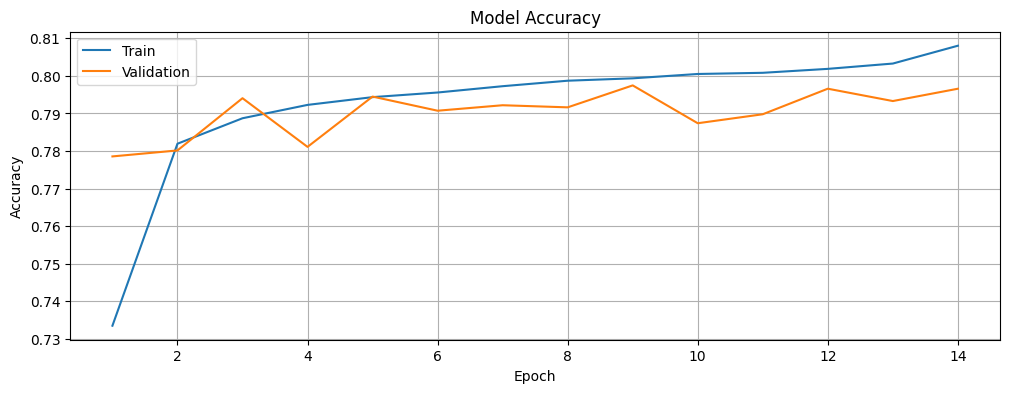

In [ ]:
plot_accuracy(history)

Let us plot the training and validation loss of the RNN model.

In [ ]:
# Function to plot the training and validation loss.
def plot_loss(history):
  # Plot the training & validation loss values.
  plt.figure(figsize=(12, 4))
  plt.plot(epochs, loss, label='loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.grid(True)
  plt.show()

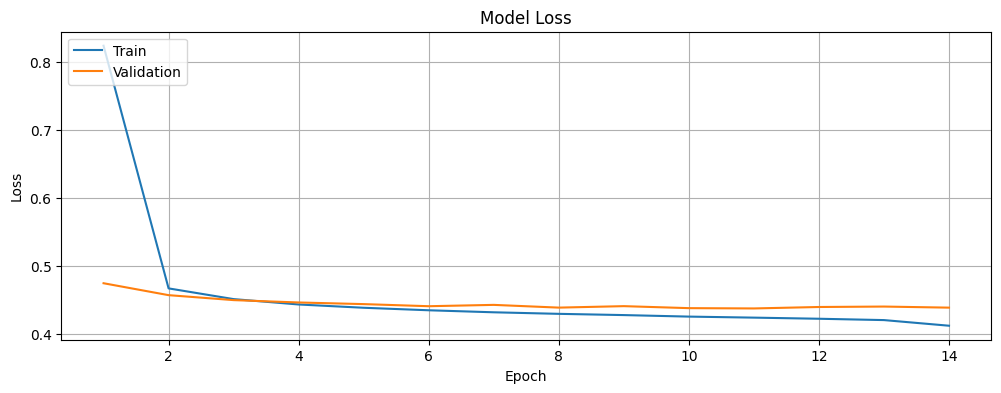

In [ ]:
plot_loss(history)

### Test the model with unseen data

We will feed the RNN model with some random text examples and see how it performs.

In [ ]:
sample_examples = tf.constant([
  "I am doing well",
  "The movie was okay.",
  "I have not been keeping well.",
  "It's a bright sunny day, let's go fishing!",
  "Great!",
  "Disaster!",
  "I am feeling confident",
  "I am not feeling confident",
])
vectorize_layer.adapt(sample_examples)

Let us go ahead and define a function that confirms whether the sentiment is *positive* or *negative* based on a threshold of 0.5, as mentioned earlier.

In [ ]:
# Output the sentiment of the given example based on a threshold.
def interpret_predictions(predictions):
    results = []
    for pred in predictions:
        if pred >= 0.5:
          results.append("Positive Sentiment")
        else:
          results.append("Negative Sentiment")
    return results

In [ ]:
# Vectorize the sample text examples.
vectorized_examples = vectorize_layer(sample_examples)

# Predict the sentiment of the sample text examples.
sample_predictions = model.predict(vectorized_examples)

# Interpret the predicted sentiments of the sample data.
sentiment_results = interpret_predictions(sample_predictions)

for result in sentiment_results:
    print(result)

1/1 [==============================] - 2s 2s/step
Negative Sentiment
Positive Sentiment
Negative Sentiment
Positive Sentiment
Negative Sentiment
Negative Sentiment
Negative Sentiment
Negative Sentiment


Investigate the probability values of the output predictions of the sample text examples to understand how close or off the predictions of the sentiments are.

In [ ]:
print(sample_predictions)

[[-0.33334756]
 [ 0.7553444 ]
 [-0.80492115]
 [ 1.1272945 ]
 [ 0.11409509]
 [ 0.12926134]
 [-0.39019266]
 [ 0.07547656]]


### Confusion Matrix

We will also plot the confusion matrix to investigate how the RNN model performs in terms of the false positives and false negatives. Let us first get the test predictions, which are probabilities, and convert them to our labels 0 and 1 based on our threshold of 0.5.

In [ ]:
# Predict with the test data.
test_predictions = model.predict(test_ds)
predicted_test_labels = (test_predictions > 0.5).astype("int32")

1/1 [==============================] - 1s 899ms/step


Next, we will define and plot the confusion matrix based on the labels in the test data and the labels predicted by the RNN model.

In [ ]:
# Confusion matrix.
cm = confusion_matrix(test_labels, predicted_test_labels)

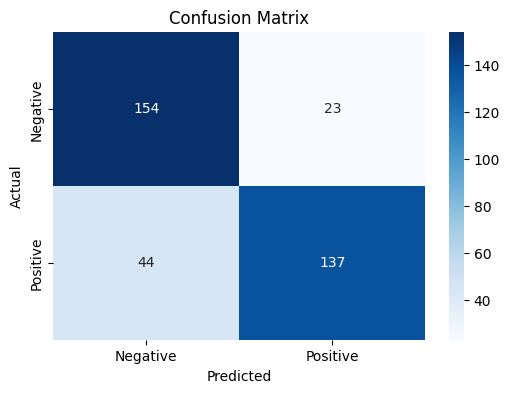

In [ ]:
# Plot the confusion matrix.
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Thoughts

The RNN model has an accuracy of about 81% and has about 23 false positives and 44 false negatives out of 358 tweets. The numbers *may* slightly vary across separate occasions of training. However, it is important to note that this is a quick and dirty implementation of a very simple RNN model, and the results are not too bad based on the same.

It is also worth noting that while the training and validation loss decreases with time, the accuracy increases, before almost stabilizing and reaching a stage where there is no further noticeable improvement. Therefore, it is unlikely that we are overfitting or underfitting the data. Although the training accuracy may seem to increase and the training loss may seem to decrease towards the end of the training indicating that the model may be prone to overfitting the training data, they would have eventually stabilized, had we allowed the training to continue by not using `EarlyStopping`. Additionally, the validation accuracy may seem to be unstable, but would have eventually stabilized had we not been using `EarlyStopping`. This can be confirmed by looking at the validation loss, that does seem to stabilize even with `EarlyStopping`.

## Next steps

Of course, there is a definite scope for improvement in this work. There are multiple ways to further develop this dirty implementation and improve the RNN model's performance / accuracy for the sentiment analysis of the tweets. Some of those are listed below.



1.   **Modifying the Architecture:** Adding more fully connected / dense layers or increasing the number of units in each layer can help the model learn more complex patterns. However, to prevent further overfitting of the training data, simplifying the architecture of the model can help instead of adding more layers.
2.   **Hyperparameter Tuning:** Experimenting with different learning rates, batch sizes, epochs, etc. can help.
3.   **Regularization:** Adjusting dropout rates and the strength of `L2` regularization can be used to control overfitting. Other techniques that can be used to prevent overfitting include learning rate warmup, or an advanced technique, such as label smoothing.
4.   **Data Augmentation:** Using techniques to augment the dataset can help, examples below.
  *   **Synonym Replacement:** Replace words with their synonyms.
  *   **Random Insertion:** Insert random words.
  *   **Random Swap:** Swap words in a sentence.
  *   **Random Deletion:** Delete random words.
5.   **Pre-trained Embeddings:** Using pre-trained word embeddings such as [GloVe](https://nlp.stanford.edu/projects/glove/) or [FastText](https://fasttext.cc/) can improve the performance of the model.
6.   **Ensemble Methods:** Using ensemble methods, such as combining predictions from multiple models can improve performance.
7.   **Fine-tuning Pre-trained Large Language Models (LLMs):** Using pre-trained LLMs, such as [BERT](https://huggingface.co/docs/transformers/en/model_doc/bert), [GPT-4](https://openai.com/index/gpt-4/), or similar models from the [Hugging Face Transformers library](https://huggingface.co/docs/transformers/en/index) can significantly uplift the performance of word-based models.
8.   **Hyperparameter Optimization:** Using libraries, such as [Keras Tuner](https://keras.io/keras_tuner/) or [Optuna](https://optuna.org/) to find the best hyperparameters for the RNN model.